In [1]:
import sys
import collections
import gc
import json
import os
import random
import time
import warnings
warnings.simplefilter("ignore")

from albumentations import *
from albumentations.pytorch import ToTensor
import cv2
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import tifffile as tiff
import timm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, sampler
from tqdm import tqdm_notebook as tqdm
from PIL import ImageDraw
import scipy.stats
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [31]:
from loaddata import *
from visualize import *
from mapping import *
from results import *

In [3]:
df_anno, df_categories, df_images = loaddata()

In [276]:
results = resultstable("track")

Read  track/topk_ids1618089130.694246.csv 136047
Read  track/topk_ids1618086371.637342.csv 136047
Read  track/topk_ids1618093280.208914.csv 136047
Read  track/topk_ids1618087711.067299.csv 136047
Read  track/topk_ids1618091843.344269.csv 136047
Total  136047
Merged  136047


In [277]:
len(results)

136047

In [278]:
df_dets = loaddets()

In [279]:
results.head()

filename  net_id  \
0  8a00a2cc-21bc-11ea-a13a-137349068a90_1.jpg    15.0   
1  8a0a5b8c-21bc-11ea-a13a-137349068a90_1.jpg    15.0   
2  8a0f5dc6-21bc-11ea-a13a-137349068a90_1.jpg    15.0   
3  8a1ad1d8-21bc-11ea-a13a-137349068a90_1.jpg    15.0   
4  8a1c892e-21bc-11ea-a13a-137349068a90_1.jpg    15.0   

                               image_id idx  \
0  8a00a2cc-21bc-11ea-a13a-137349068a90   1   
1  8a0a5b8c-21bc-11ea-a13a-137349068a90   1   
2  8a0f5dc6-21bc-11ea-a13a-137349068a90   1   
3  8a1ad1d8-21bc-11ea-a13a-137349068a90   1   
4  8a1c892e-21bc-11ea-a13a-137349068a90   1   

                                 seq_id  category_id           name  
0  300ce310-7d42-11eb-8fb5-0242ac1c0002           24  panthera onca  
1  300a9452-7d42-11eb-8fb5-0242ac1c0002           24  panthera onca  
2  301f2854-7d42-11eb-8fb5-0242ac1c0002           24  panthera onca  
3  3016e0d6-7d42-11eb-8fb5-0242ac1c0002           24  panthera onca  
4  5a2416fc-7ed0-11eb-b7d6-0242ac1c0002           24  panthera onca

In [280]:
merged = load_merged()

In [248]:
df_images[df_images["image_id"]=="94563836-21bc-11ea-a13a-137349068a90"]

seq_num_frames  location                 datetime  \
73945               3       387  2015-02-11 02:44:43.000   

                                   image_id  \
73945  94563836-21bc-11ea-a13a-137349068a90   

                                     seq_id  width  height  \
73945  9782111a-21bc-11ea-a13a-137349068a90   1280    1024   

                                      file_name  sub_location  seq_frame_num  
73945  94563836-21bc-11ea-a13a-137349068a90.jpg           NaN              0

In [282]:
# check if all values are ok
results[results.isnull().sum(axis=1) > 0]

Empty DataFrame
Columns: [filename, net_id, image_id, idx, seq_id, category_id, name]
Index: []

In [261]:
sequences = results["seq_id"].unique()
merged[merged["image_id"] == "976129dc-21bc-11ea-a13a-137349068a90"]

id  \
162374  9a29dd26-21bc-11ea-a13a-137349068a90   

                                    image_id  category_id  \
162374  976129dc-21bc-11ea-a13a-137349068a90          417   

                         name  seq_num_frames  location  \
162374  myiophoneus caeruleus               3        61   

                       datetime                                seq_id  width  \
162374  2013-06-29 18:07:41.000  98fc8d0e-21bc-11ea-a13a-137349068a90   2048   

        height                                 file_name  sub_location  \
162374    1536  976129dc-21bc-11ea-a13a-137349068a90.jpg           NaN   

        seq_frame_num                                         detections  \
162374              0  [{'category': '1', 'bbox': [0.0939, 0.2537, 0....   

        max_detection_conf  
162374               0.986

In [289]:
# group categories per image
# count all categories per image
pred = collections.defaultdict(list)
for i, row in results.iterrows():
    image_id = row["image_id"]
    category = int(row["net_id"])
    idx = int(row["idx"])
    pred[image_id].append(category)

In [290]:
len(pred)

83612

In [292]:
for p in pred:
    if len(set(pred[p])) > 1:
        print(p,set(pred[p]))

8ad917a6-21bc-11ea-a13a-137349068a90 {24, 25, 15}
8bf11bde-21bc-11ea-a13a-137349068a90 {164, 15}
8d1cadde-21bc-11ea-a13a-137349068a90 {1, 15}
8d55f512-21bc-11ea-a13a-137349068a90 {4, 15}
8f49d3f2-21bc-11ea-a13a-137349068a90 {163, 15}
8fd83994-21bc-11ea-a13a-137349068a90 {2, 15}
89ecb550-21bc-11ea-a13a-137349068a90 {1, 6, 15}
92bb63de-21bc-11ea-a13a-137349068a90 {163, 15}
92fc14f6-21bc-11ea-a13a-137349068a90 {8, 15}
879b25de-21bc-11ea-a13a-137349068a90 {39, 15}
982aa5b4-21bc-11ea-a13a-137349068a90 {163, 15}
90796fc6-21bc-11ea-a13a-137349068a90 {164, 15}
8a0c8cae-21bc-11ea-a13a-137349068a90 {163, 164}
8a4d18dc-21bc-11ea-a13a-137349068a90 {163, 6}
8a4ec952-21bc-11ea-a13a-137349068a90 {1, 162, 163}
8a34cc0a-21bc-11ea-a13a-137349068a90 {163, 164}
8a52f8b0-21bc-11ea-a13a-137349068a90 {41, 163}
8a57ee06-21bc-11ea-a13a-137349068a90 {163, 164}
8a80f4c2-21bc-11ea-a13a-137349068a90 {17, 163}
8a83e4ac-21bc-11ea-a13a-137349068a90 {162, 163}
8a0239c0-21bc-11ea-a13a-137349068a90 {169, 163}
8a350d82-2

87acff02-21bc-11ea-a13a-137349068a90 {29, 38}
87b1f566-21bc-11ea-a13a-137349068a90 {45, 38}
87b35e42-21bc-11ea-a13a-137349068a90 {45, 38}
87b01228-21bc-11ea-a13a-137349068a90 {29, 38}
87bc5830-21bc-11ea-a13a-137349068a90 {43, 38}
87c86c06-21bc-11ea-a13a-137349068a90 {104, 38}
87cd4730-21bc-11ea-a13a-137349068a90 {29, 38}
87cf8c20-21bc-11ea-a13a-137349068a90 {0, 38}
87d535ee-21bc-11ea-a13a-137349068a90 {24, 43, 38}
87dbbea0-21bc-11ea-a13a-137349068a90 {58, 38}
87f98afc-21bc-11ea-a13a-137349068a90 {45, 38}
87f712ae-21bc-11ea-a13a-137349068a90 {45, 38}
87fa4b36-21bc-11ea-a13a-137349068a90 {45, 38}
87fcce6a-21bc-11ea-a13a-137349068a90 {45, 38}
88a6de8c-21bc-11ea-a13a-137349068a90 {45, 38}
88a34088-21bc-11ea-a13a-137349068a90 {45, 38}
88ae0ee6-21bc-11ea-a13a-137349068a90 {45, 38}
88b66a00-21bc-11ea-a13a-137349068a90 {29, 38}
88b93ece-21bc-11ea-a13a-137349068a90 {24, 38}
88b95d1e-21bc-11ea-a13a-137349068a90 {24, 38}
88b13490-21bc-11ea-a13a-137349068a90 {32, 50, 38}
88ba6628-21bc-11ea-a13a-13

In [121]:
query_image = "8a7c46de8ad917a6-21bc-11ea-a13a-137349068a90" # cattle
#query_image = "89fad9f0-21bc-11ea-a13a-137349068a90" # {163, 164, 127}
#query_image = "90f74a36-21bc-11ea-a13a-137349068a90" # {49, 163, 132, 29}
print(pred[query_image])

[34, 38, 24, 24, 24, 43, 25, 42, 89]


In [ ]:
# todo load train_box_split

In [205]:
def get_seqid(query_image):
    return df_images[df_images["image_id"] == query_image].iloc[0]["seq_id"]

get_seqid(query_image)

'302378d2-7d42-11eb-8fb5-0242ac1c0002'

In [322]:
def lll(qi):
    seq_id = get_seqid(qi)
    print("seq_id=", seq_id)
    images = merged[merged["seq_id"] == seq_id]
    
    for i, im in images.iterrows():
        im_id = im["image_id"]
        print(im_id, pred[im_id])
        print((im["detections"]))

        
    visualize_sequence(merged, seq_id,
                   overlay=True, results=results)

seq_id= 30005668-7d42-11eb-8fb5-0242ac1c0002
8d38b3a8-21bc-11ea-a13a-137349068a90 [24, 106]
[{'category': '1', 'bbox': [0.4875, 0.5865, 0.1683, 0.1277], 'conf': 0.999}, {'category': '1', 'bbox': [0.076, 0.568, 0.0633, 0.1035], 'conf': 0.96}, {'category': '1', 'bbox': [0.7167, 0.5911, 0.0691, 0.0668], 'conf': 0.761}, {'category': '1', 'bbox': [0.1879, 0.5793, 0.0521, 0.0621], 'conf': 0.638}, {'category': '1', 'bbox': [0.2275, 0.5771, 0.0883, 0.0833], 'conf': 0.446}]
8f1ea4a2-21bc-11ea-a13a-137349068a90 [24, 24, 24]
[{'category': '1', 'bbox': [0.3373, 0.5856, 0.1683, 0.129], 'conf': 1.0}, {'category': '1', 'bbox': [0.0011, 0.5895, 0.0805, 0.0983], 'conf': 0.93}, {'category': '1', 'bbox': [0.1978, 0.5912, 0.0547, 0.0569], 'conf': 0.909}, {'category': '1', 'bbox': [0.6824, 0.573, 0.15, 0.103], 'conf': 0.776}, {'category': '1', 'bbox': [0.9733, 0.5795, 0.0267, 0.1187], 'conf': 0.389}]
8b9c17b0-21bc-11ea-a13a-137349068a90 [24, 24, 24]
[{'category': '1', 'bbox': [0.4039, 0.5822, 0.1768, 0.130

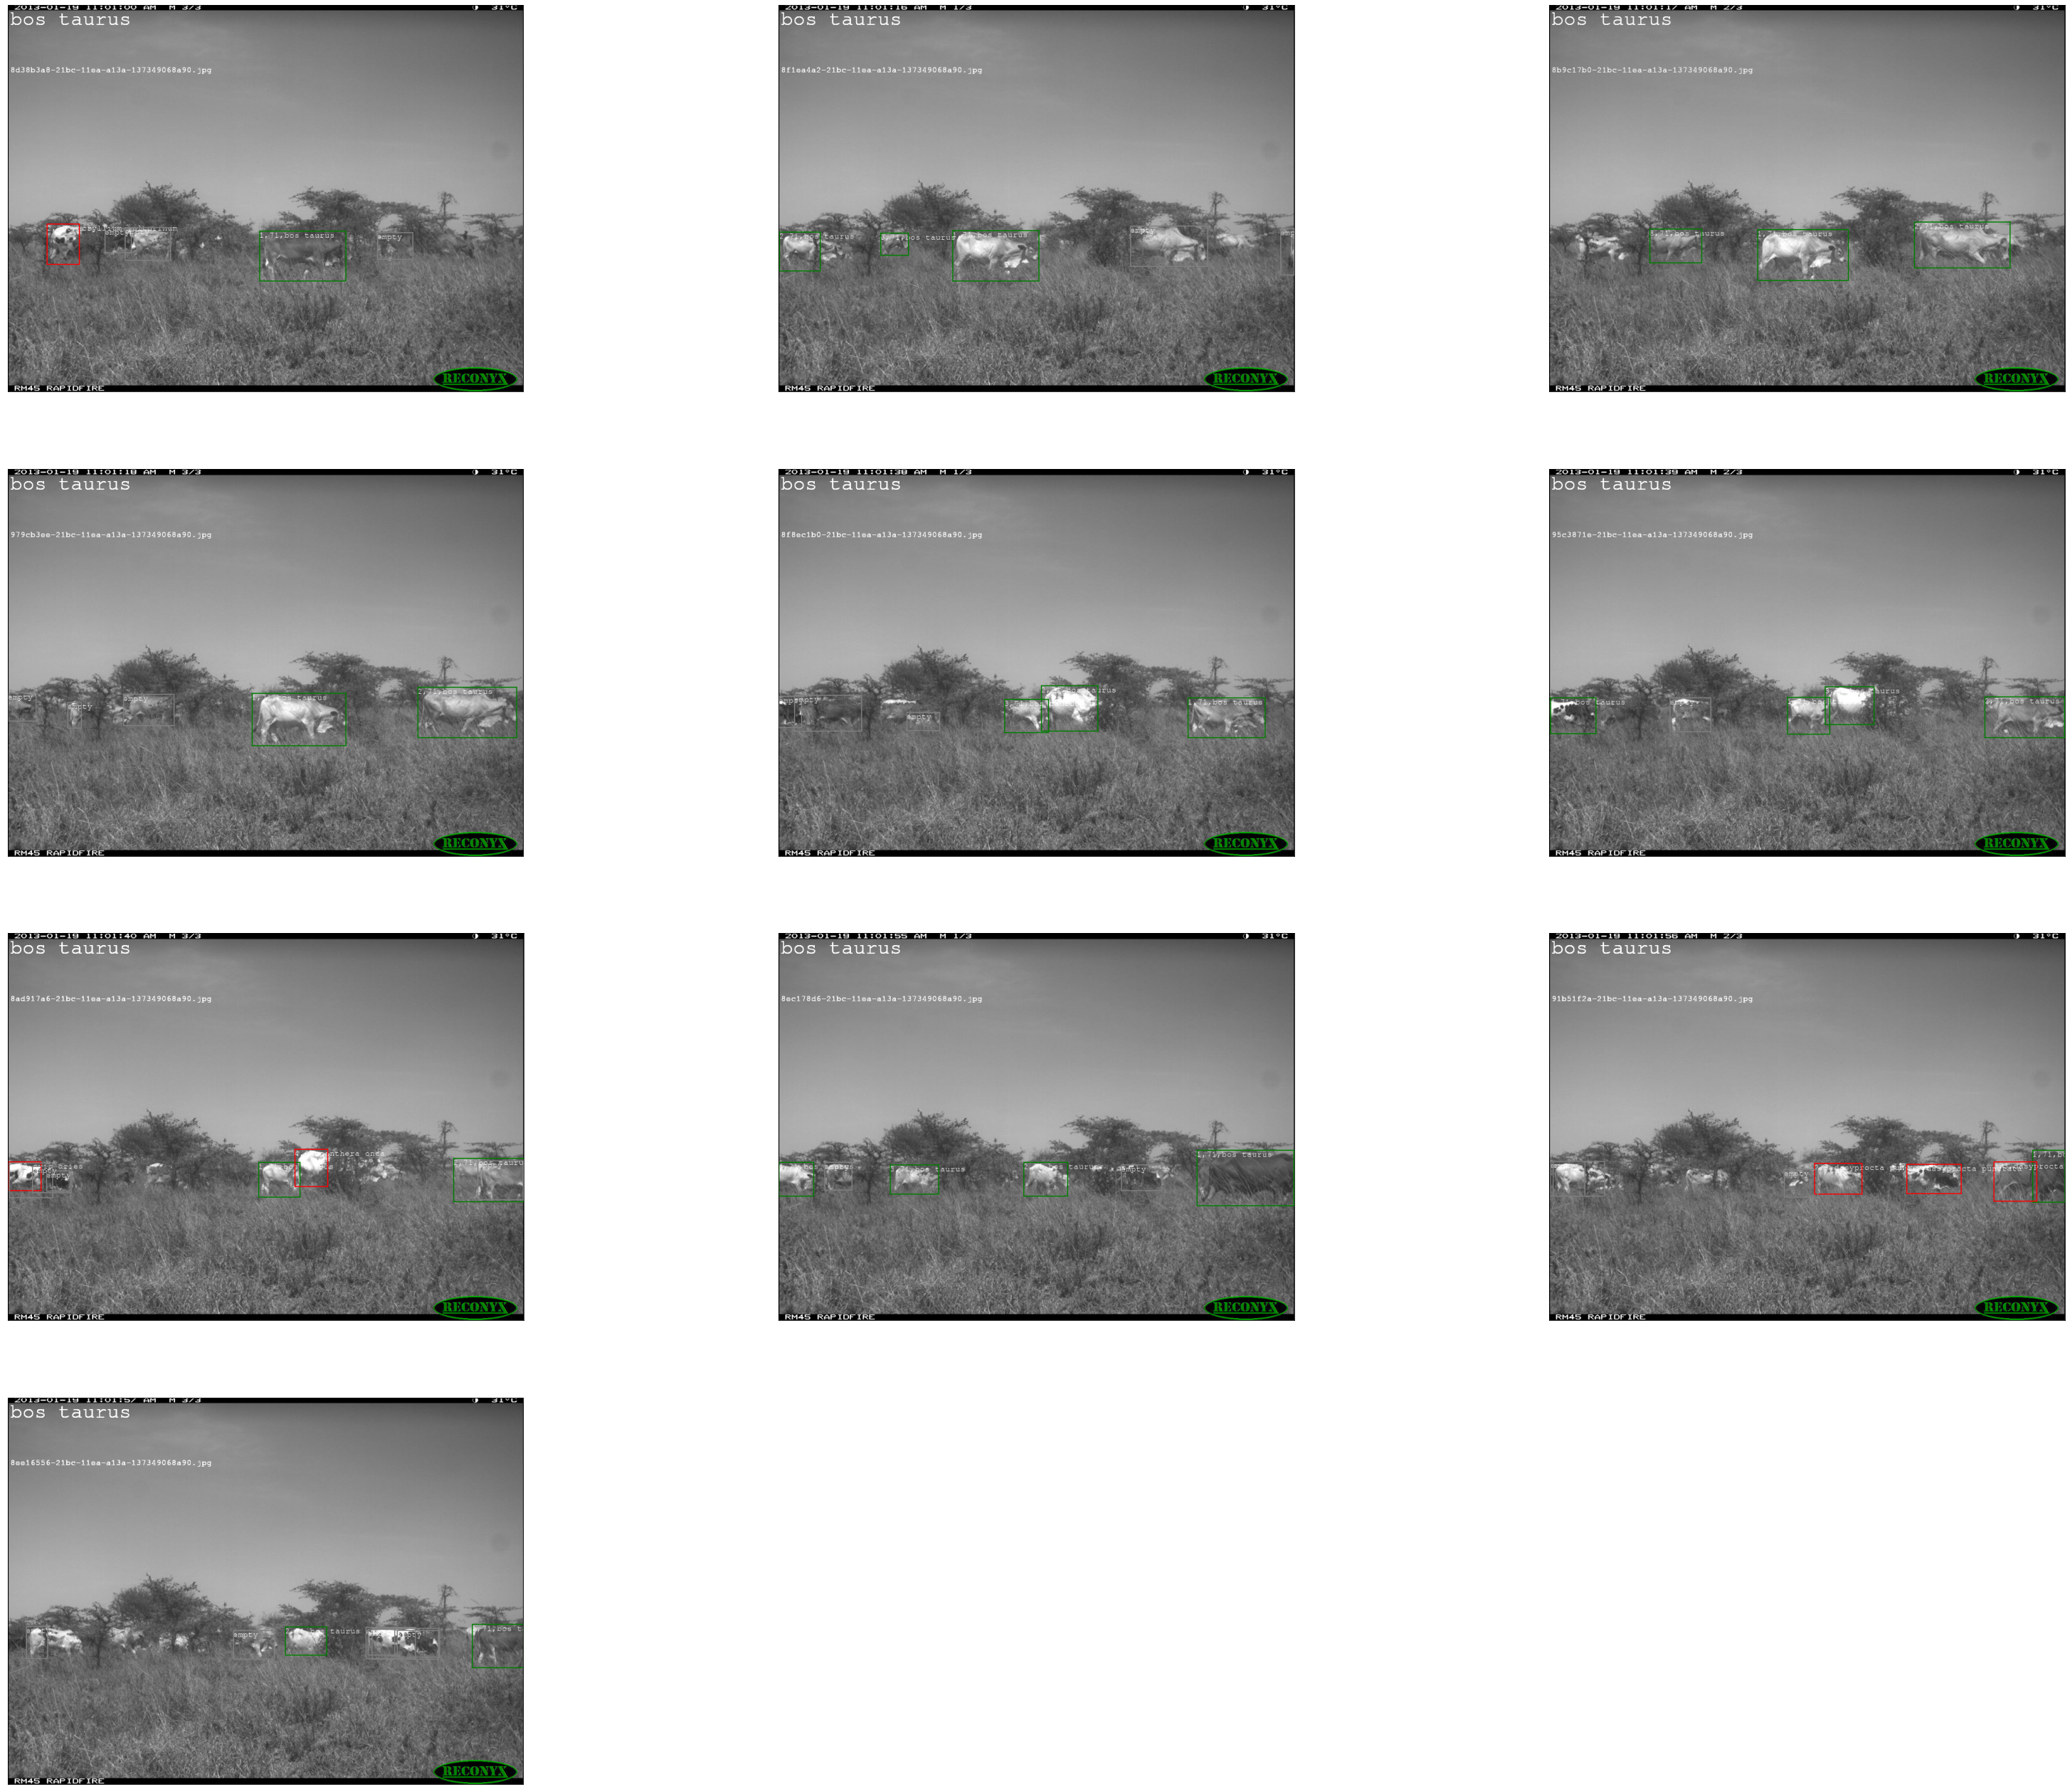

In [323]:
lll("8ad917a6-21bc-11ea-a13a-137349068a90")

In [33]:
merged = netid(merged)

In [129]:
merged[merged["image_id"] == query_image]

id  \
110100  9d3db6cc-21bc-11ea-a13a-137349068a90   

                                    image_id  category_id        name  \
110100  8a7c46de-21bc-11ea-a13a-137349068a90           71  bos taurus   

        seq_num_frames  location                 datetime  \
110100               8        31  2013-01-22 08:19:49.000   

                                      seq_id  width  height  \
110100  302378d2-7d42-11eb-8fb5-0242ac1c0002   1280    1024   

                                       file_name  sub_location  seq_frame_num  \
110100  8a7c46de-21bc-11ea-a13a-137349068a90.jpg           NaN              1   

                                               detections  max_detection_conf  \
110100  [{'category': '1', 'bbox': [0.074, 0.5683, 0.1...               0.998   

        net_id  
110100      24

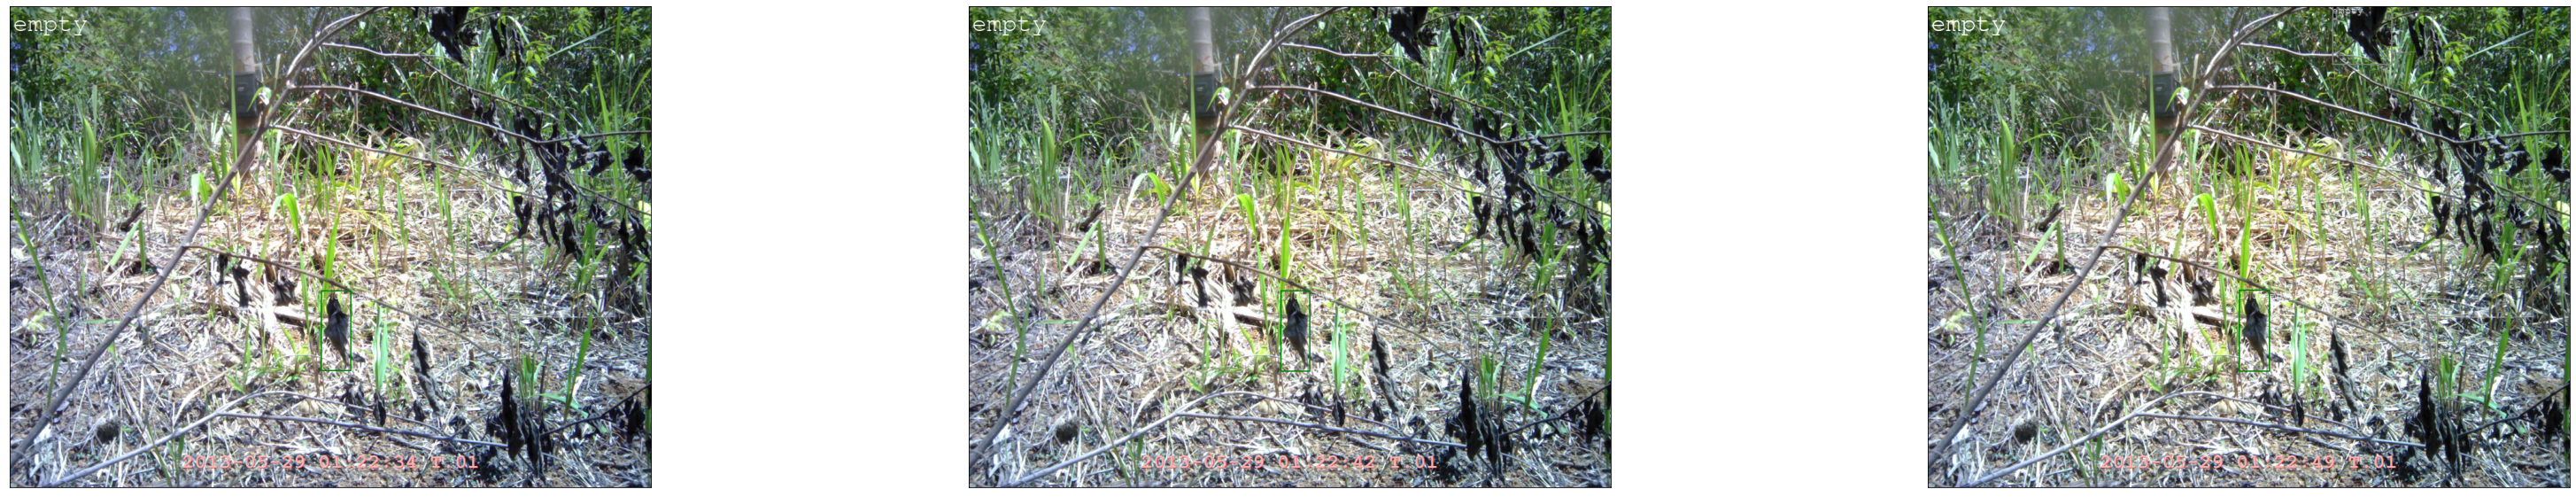

In [274]:
visualize_sequence(merged, "99336ebe-21bc-11ea-a13a-137349068a90" ,
                   overlay=True, results=results)

In [14]:
image = df_images[df_images["image_id"] == query_image]

In [208]:
image

seq_num_frames  location                 datetime  \
78344              10       408  2013-07-12 05:24:43.000   

                                   image_id  \
78344  90f74a36-21bc-11ea-a13a-137349068a90   

                                     seq_id  width  height  \
78344  300bb332-7d42-11eb-8fb5-0242ac1c0002   1280    1024   

                                      file_name  sub_location  seq_frame_num  
78344  90f74a36-21bc-11ea-a13a-137349068a90.jpg           NaN              8

In [264]:
def calc_mode(image_ids):
    lengths = []
    vals = []
    for im_id in image_ids:
        im_id = str(im_id)
        lengths.append(len(pred[im_id]))
        vals.extend(pred[im_id])
#        print(pred[im_id])
    if len(vals) > 0:
        v = scipy.stats.mode(vals)[0][0]
    else:
        v = 0
    return v, np.sum(lengths) / len(image_ids)

In [268]:
# make a list of counters that matches the submission format already
counters = []

for i, seq in enumerate(tqdm(sequences)):
    images = merged[merged["seq_id"] == seq]
#    print(images["image_id"])
    image_ids = [str(im["image_id"]) for i,im in images.iterrows()]
    category, count = calc_mode(image_ids)
    c = collections.Counter(seq)
    res = []
    cnts = [0 for i in range(205)]
    
    if(category > 0):
        cnts[category] = count
        
    res += [seq] + cnts[1:]
    counters.append(res)

  0%|          | 0/15860 [00:00<?, ?it/s]

In [269]:
new_tmp = pd.DataFrame(counters)
new_tmp.shape

(15860, 205)

In [270]:
new_tmp[new_tmp.sum(axis=1)==0].head(40)

0    1    2    3    4    5    6    \
2013   30128d06-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
3435   9685c09a-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
3641   2ffd1d90-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
3715   970a4d2e-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
4539   94ffeeb2-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
4897   302fa3c8-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
5044   302c16fe-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
5082   98b98e78-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
6997   3009a0ce-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
8641   2ffd1e94-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
10711  909bdb7e-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10712  95adf4da-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10713  8b18e8d6-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10714  3023d55c-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
10715  96ac2212-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10716  9042c782-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10717  956a6828-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10718  96c4aac6-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10719  8abe19ec-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10720  302dd73c-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
10721  302debe6-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
10722  302f59a4-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
10724  8d190526-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10725  991da8e0-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10726  92701280-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10727  302ef180-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
10728  98c0247c-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10729  97ea9046-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10730  2fffe8c2-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
10731  30046dc0-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
10732  302fad5a-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
10733  30282936-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
10734  8a450d90-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10735  3028ed58-7d42-11eb-8fb5-0242ac1c0002  0.0  0.0  0.0  0.0  0.0  0.0   
10736  8a70144a-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10737  8df64f30-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10738  972dea0e-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10739  8cdc8d9e-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10740  973bded4-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   
10741  99336ebe-21bc-11ea-a13a-137349068a90  0.0  0.0  0.0  0.0  0.0  0.0   

       7    8    9    ...  195  196  197  198  199  200  201  202  203  204  
2013   0.0  0.0  0.0  ...  0.0  0.0  0.0    0  0.0  0.0  0.0  0.0  0.0  0.0  
3435   0.0  0.0  0.0  ...  0.0  0.0  0.0    0  0.0  0.0  0.0  0.0  0.0  0.0  
3641   0.0  0.0  0.0  ...  0.0  0.0  0.0    0  0.0  0.0  0.0  0.0  0.0  0.0  
3715   0.0  0.0  0.0  ...  0.0  0.0  0.0    0  0.0  0.0  0.0  0.0  0.0  0.0  
4539   0.0  0.0  0.0  ...  0.0  0.0  0.0    0  0.0  0.0  0.0  0.0  0.0  0.0  
4897   0.0  0.0  0.0  ...  0.0  0.0  0.0    0  0.0  0.0  0.0  0.0  0.0  0.0  
5044   0.0  0.0  0.0  ...  0.0  0.0  0.0    0  0.0  0.0  0.0  0.0  0.0  0.0  
5082   0.0  0.0  0.0  ...  0.0  0.0  0.0    0  0.0  0.0  0.0  0.0  0.0  0.0  
6997   0.0  0.0  0.0  ...  0.0  0.0  0.0    0  0.0  0.0  0.0  0.0  0.0  0.0  
8641   0.0  0.0  0.0  ...  0.0  0.0  0.0    0  0.0  0.0  0.0  0.0  0.0  0.0  
10711  0.0  0.0  0.0  ..

In [195]:
images = merged[merged["seq_id"] == "8bbfdc86-21bc-11ea-a13a-137349068a90"]

In [196]:
image_ids = [im["image_id"] for i,im in images.iterrows()]

In [197]:
image_ids

['8bbfda92-21bc-11ea-a13a-137349068a90']

In [198]:
pred["8bbfda92-21bc-11ea-a13a-137349068a90"]

[]

In [128]:
lengths = []
vals = []
for im_id in image_ids:
    print(pred[im_id])
    lengths.append(len(pred[im_id]))
    vals.extend(pred[im_id])
#    print(pred[im_id])
v = scipy.stats.mode(vals)[0][0]
print(v,np.mean(lengths))

[63, 34, 34, 34, 45, 24, 24, 24, 25, 41]
[34, 38, 24, 24, 24, 43, 25, 42, 89]
[45, 45, 45, 24, 24, 24, 24, 43]
[45, 24, 24, 24, 24, 43, 110, 110, 195]
[34, 38, 45, 24, 24, 43, 195, 195, 42]
[24, 24, 24]
[24, 24, 24, 42]
[38, 24, 24, 24]
24 7.0


In [112]:
for im_id in image_ids:
    print(pred[im_id])

[163, 163, 163, 163, 163, 163, 163]
[132, 132, 132, 132, 132]
[163, 163, 163, 163, 163]
[163, 163, 163, 163, 163]
[163, 163, 163, 163, 163]
[163, 163, 163, 163, 163]
[163, 163, 163, 163, 163, 163]
[163, 163, 163, 163, 163]
[29, 29, 29, 29]
[11, 11, 11, 11, 11, 11]


In [130]:
# make a list of counters that matches the submission format already
counters = []

for image_id in image_ids:
    c = collections.Counter(pred[image_id])
    res = []
    cnts = [ 0 for i in range(205)]
    for category, cnt in c.items():
        cnts[category] = cnt
    res += [image_id] + cnts[1:]
    counters.append(res)

In [131]:
df_counters = pd.DataFrame(counters)
score_columns = df_counters.columns[1:]
df_counters = df_counters[score_columns]

In [132]:
df_counters.head()

1    2    3    4    5    6    7    8    9    10   ...  195  196  197  198  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    1    0    0    0   
4    0    0    0    0    0    0    0    0    0    0  ...    2    0    0    0   

   199  200  201  202  203  204  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 204 columns]

In [133]:
cnt_mean = df_counters.mean(numeric_only=True).fillna(0)
cnt_median = df_counters.median(numeric_only=True).fillna(0)
cnt_max = df_counters.max(numeric_only=True).fillna(0)
cnt_mode = df_counters.agg(lambda x: scipy.stats.mode(x)[0][0]).fillna(0)


In [134]:
cnt = { "max" : cnt_max,
       "mean" : cnt_mean,
        "median" : cnt_median,
        "mode" : cnt_median}

In [135]:
for k,v in cnt.items():
    print(k)
    m = v
    df = pd.DataFrame(m[m>0])
#    df.index = [i for i in df.index]
    print(df.head())

max
    0
24  4
25  1
34  3
38  1
41  1
mean
        0
24  3.125
25  0.250
34  0.625
38  0.375
41  0.125
median
      0
24  3.0
43  0.5
45  0.5
mode
      0
24  3.0
43  0.5
45  0.5


In [81]:
m[0]=0

In [82]:
m[m>0]

163    5.0
dtype: float64

In [83]:
df = pd.DataFrame(m[m>0])
df.index = [i for i in df.index]
df

0
163  5.0